<p align = "center"><strong>GLOBAL SPATIAL AUTOCORRELATION: MORAN’S I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Bivariate Global Moran's Index__
__Def.__

Estadístico global de covariación entre una variable focal y una variable contextual, en el cual se considera una matriz de vecindad de pesos W.

El índice toma valores :
- $ I_{XY} > 0  \qquad \to\qquad$   presencia de __covariación positiva__
- $ I_{XY} \approx 0 \qquad \to \qquad$ __no existe covariación__
- $ I_{XY} < 0 \qquad \to \qquad$  presencia de __covariación negativa__

__Formula:__

Suma de pesos espaciales 
$$S_0 = \sum_{j=1}^{m}\sum_{i=1}^{n} w_{ij} $$

Desviaciones respecto la media

$$\bar{z}_i^x = x_i - \bar{x} \qquad \bar{z}_i^y = y_i - \bar{y}$$
Índice de Moran

$$ I_{XY} =
\frac{n}{S_0}\;
\frac{\sum_{i=1}^{n}\sum_{j=1}^{m} w_{ij} z_i z_j}
{\sum_{i=1}^{n} z_i^2}
$$

Valor esperado 

$$E(I) \approx -\frac{1}{n-1} $$

<p align = 'center'> <em>Bajo el supuesto de aleatoriedad espacial, el valor esperado del índice de Moran es cercano a cero para muestras grandes</em></p>

donde : 
- $w_{ij}$ elemento de la matrix de pesos espaciales $W$
- $x_i$ valor observado de la variable de interés en la unidad espacial $i$.
- $x_j$ valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$)
- $n$ número de unidades espaciales.
- $z_i$ valor centrado (no normalizado) de la observación $i$.

__Reference:__
- Spatial Analysis Online. (s.f.). *Global Spatial Autocorrelation (Moran’s I and Geary’s C)*.  
  https://www.spatialanalysisonline.com/HTML/index.html?global_spatial_autocorrelation.htm


__Code :__

In [ ]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from libpysal.weights import Queen, Rook, W, lag_spatial, w_subset
from esda.moran import Moran_BV
import warnings
import contextlib


def global_moran_bv(
    gdf: gpd.GeoDataFrame,
    x_fields,
    y_fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 9999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_xy: bool = True,
    use_index: bool = True,
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_pair: tuple[str, str] | None = None,
    figsize=(15, 10),
):
    """
    GLOBAL Bivariate Moran's I (Moran_BV) for multiple (X,Y) pairs and contiguities.

    Scatter: z(X) vs lag(z(Y))
    Hist: permutation distribution for I_xy

    Notes:
      - GeoDa uses row-standardized weights -> w.transform="R"
      - In some esda versions Moran_BV may not have EI; we use E[I] = -1/(n-1).
    """

    # BASIC INPUT HANDLING
    if isinstance(x_fields, str):
        x_fields = [x_fields]
    if isinstance(y_fields, str):
        y_fields = [y_fields]

    x_fields = list(x_fields)
    y_fields = list(y_fields)

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # validate columns
    missing = [c for c in set(x_fields + y_fields) if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    # build (x,y) pairs with broadcast rules
    if len(x_fields) == len(y_fields):
        pairs = list(zip(x_fields, y_fields))
    elif len(y_fields) == 1:
        pairs = [(x, y_fields[0]) for x in x_fields]
    elif len(x_fields) == 1:
        pairs = [(x_fields[0], y) for y in y_fields]
    else:
        raise ValueError(
            "x_fields and y_fields must have same length, or one of them must have length 1."
        )

    if dashboard_pair is None:
        dashboard_pair = pairs[0]
    if dashboard_pair not in pairs:
        raise ValueError("dashboard_pair must be one of the generated (x,y) pairs")

    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # CONTEXT MANAGERS
    @contextlib.contextmanager
    def _maybe_style(style_name):
        old = plt.rcParams.copy()
        try:
            plt.style.use(style_name)
            yield
        finally:
            plt.rcParams.update(old)

    @contextlib.contextmanager
    def _maybe_warnings(silence):
        if not silence:
            yield
            return
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message=".*weights matrix is not fully connected.*",
            )
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=".*use_index.*",
            )
            yield

    # HELPERS
    def _zscore(v):
        v = np.asarray(v, dtype=float)
        sd = v.std(ddof=0)
        return (v - v.mean()) / sd if sd > 0 else v * 0.0

    def _build_weights(df):
        wq = Queen.from_dataframe(df, use_index=use_index)
        wr = Rook.from_dataframe(df, use_index=use_index)

        outw = {}
        if "queen" in contiguities:
            outw["queen"] = wq
        if "rook" in contiguities:
            outw["rook"] = wr
        if "bishop" in contiguities:
            ids = list(wq.id_order)
            neighbors = {
                i: list(set(wq.neighbors.get(i, [])) - set(wr.neighbors.get(i, [])))
                for i in ids
            }
            outw["bishop"] = W(neighbors, id_order=ids)

        return outw

    def _subset_drop_islands(w, df):
        ids = list(df.index) if use_index else list(range(len(df)))
        w2 = w_subset(w, ids)

        islands_initial = list(getattr(w2, "islands", []))

        if drop_islands and islands_initial:
            df2 = df.drop(index=islands_initial).copy() if use_index else df.copy()
            ids2 = list(df2.index) if use_index else list(range(len(df2)))
            w2 = w_subset(w, ids2)
            return w2, df2, islands_initial

        return w2, df, islands_initial

    def _safe_float(obj, attr, default=np.nan):
        return float(getattr(obj, attr, default)) if getattr(obj, attr, None) is not None else float(default)

    # RESULTS TABLE
    rows = []

    with _maybe_warnings(silence_warnings), _maybe_style(style):

        w_full = _build_weights(gdf)

        for (x_name, y_name) in pairs:
            for c in contiguities:

                w2, df2, islands_initial = _subset_drop_islands(w_full[c], gdf)
                w2.transform = "R"  # GeoDa style

                x = df2[x_name].to_numpy()
                y = df2[y_name].to_numpy()

                n = len(x)

                # degenerate
                if n < 3 or np.std(x, ddof=0) == 0 or np.std(y, ddof=0) == 0:
                    rows.append(dict(
                        x=x_name,
                        y=y_name,
                        contiguity=c.upper(),
                        n=int(n),
                        var_x=float(np.var(x, ddof=0)),
                        var_y=float(np.var(y, ddof=0)),
                        Moran_BV_I=np.nan,
                        E_I=float(-1 / (n - 1)) if n > 1 else np.nan,
                        z_sim=np.nan,
                        p_value_perm=np.nan,
                        significant_alpha=False,
                        permutations=int(permutations),
                        islands_initial=int(len(islands_initial)),
                        islands_removed=int(len(islands_initial)) if drop_islands else 0,
                        islands_remaining=int(len(getattr(w2, "islands", []))),
                        note="n<3 or zero variance in x or y",
                    ))
                    continue

                x_use = _zscore(x) if standardize_xy else x.copy()
                y_use = _zscore(y) if standardize_xy else y.copy()

                mi_bv = Moran_BV(x_use, y_use, w2, permutations=permutations)

                # EI may not exist -> use -1/(n-1)
                E_I = float(getattr(mi_bv, "EI", -1 / (n - 1)))

                rows.append(dict(
                    x=x_name,
                    y=y_name,
                    contiguity=c.upper(),
                    n=int(n),
                    var_x=float(np.var(x_use, ddof=0)),
                    var_y=float(np.var(y_use, ddof=0)),
                    Moran_BV_I=float(mi_bv.I),
                    E_I=float(E_I),
                    z_sim=_safe_float(mi_bv, "z_sim", np.nan),
                    p_value_perm=_safe_float(mi_bv, "p_sim", np.nan),
                    significant_alpha=bool(getattr(mi_bv, "p_sim", 1.0) < alpha),
                    permutations=int(permutations),
                    islands_initial=int(len(islands_initial)),
                    islands_removed=int(len(islands_initial)) if drop_islands else 0,
                    islands_remaining=int(len(getattr(w2, "islands", []))),
                    note="",
                ))

        results_table = pd.DataFrame(rows)
        order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
        results_table["contiguity"] = (
            results_table["contiguity"].astype(str).str.upper().astype(order)
        )
        results_table = results_table.sort_values(["x", "y", "contiguity"]).reset_index(drop=True)

        # graph (one pair)
        dash = {}
        kinds = list(contiguities)
        x_dash, y_dash = dashboard_pair

        for kind in kinds:
            w2, df2, _ = _subset_drop_islands(w_full[kind], gdf)
            w2.transform = "R"

            x = df2[x_dash].to_numpy()
            y = df2[y_dash].to_numpy()

            x_use = _zscore(x) if standardize_xy else x.copy()
            y_use = _zscore(y) if standardize_xy else y.copy()

            mi_bv = Moran_BV(x_use, y_use, w2, permutations=permutations)

            # Scatter: z(X) vs lag(z(Y))
            x_plot = x_use
            wy_plot = lag_spatial(w2, y_use)

            dash[kind] = dict(
                gdf=df2,
                w=w2,
                x=x_use,
                y=y_use,
                mi_bv=mi_bv,
                x_plot=x_plot,
                wy_plot=wy_plot,
            )

        fig, axes = plt.subplots(len(kinds), 2, figsize=figsize)
        if len(kinds) == 1:
            axes = np.array([axes])

        for r, kind in enumerate(kinds):
            mi_bv = dash[kind]["mi_bv"]
            x_plot = dash[kind]["x_plot"]
            wy_plot = dash[kind]["wy_plot"]

            # scatter
            ax_sc = axes[r, 0]
            ax_sc.scatter(x_plot, wy_plot, edgecolor="k", facecolor="none")
            ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)

            xx = np.linspace(np.min(x_plot), np.max(x_plot), 100)
            ax_sc.plot(xx, mi_bv.I * xx, linewidth=2)

            ax_sc.set_title(
                f"{kind.upper()} — Bivariate Moran Scatter (Ixy={mi_bv.I:.3f})",
                fontweight="bold",
            )
            ax_sc.set_xlabel(f"{x_dash} ({'std' if standardize_xy else 'raw'})")
            ax_sc.set_ylabel(f"Spatial lag of {y_dash}")

            # perm histogram
            ax_ph = axes[r, 1]
            sim = getattr(mi_bv, "sim", None)
            if sim is not None:
                ax_ph.hist(sim, bins=30, edgecolor="black")
                ax_ph.axvline(mi_bv.I, linewidth=2)
                ax_ph.set_title(
                    f"{kind.upper()} — Permutations (p={getattr(mi_bv, 'p_sim', np.nan):.4f})",
                    fontweight="bold",
                )
            else:
                ax_ph.text(0.5, 0.5, "No permutation distribution available", ha="center", va="center")
                ax_ph.set_title(f"{kind.upper()} — Permutations", fontweight="bold")
            ax_ph.set_xlabel("Bivariate Moran's I")
            ax_ph.set_ylabel("Frequency")

        fig.suptitle(
            f"GLOBAL BIVARIATE MORAN'S I — ({x_dash} , {y_dash})",
            y=1.02,
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    out = {"dashboard": dash, "results_table": results_table, "pairs": pairs}
    return results_table, fig, out


,x,y,contiguity,n,var_x,var_y,Moran_BV_I,E_I,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,BirthRate,Below_evel,QUEEN,77,1.0,1.0,0.148304,-0.013158,2.151779,0.024,True,999,0,0,0,
1,BirthRate,Below_evel,ROOK,77,1.0,1.0,0.141568,-0.013158,1.958756,0.025,True,999,0,0,0,
2,BirthRate,Below_evel,BISHOP,31,1.0,1.0,0.063016,-0.033333,0.298229,0.370,False,999,46,46,0,


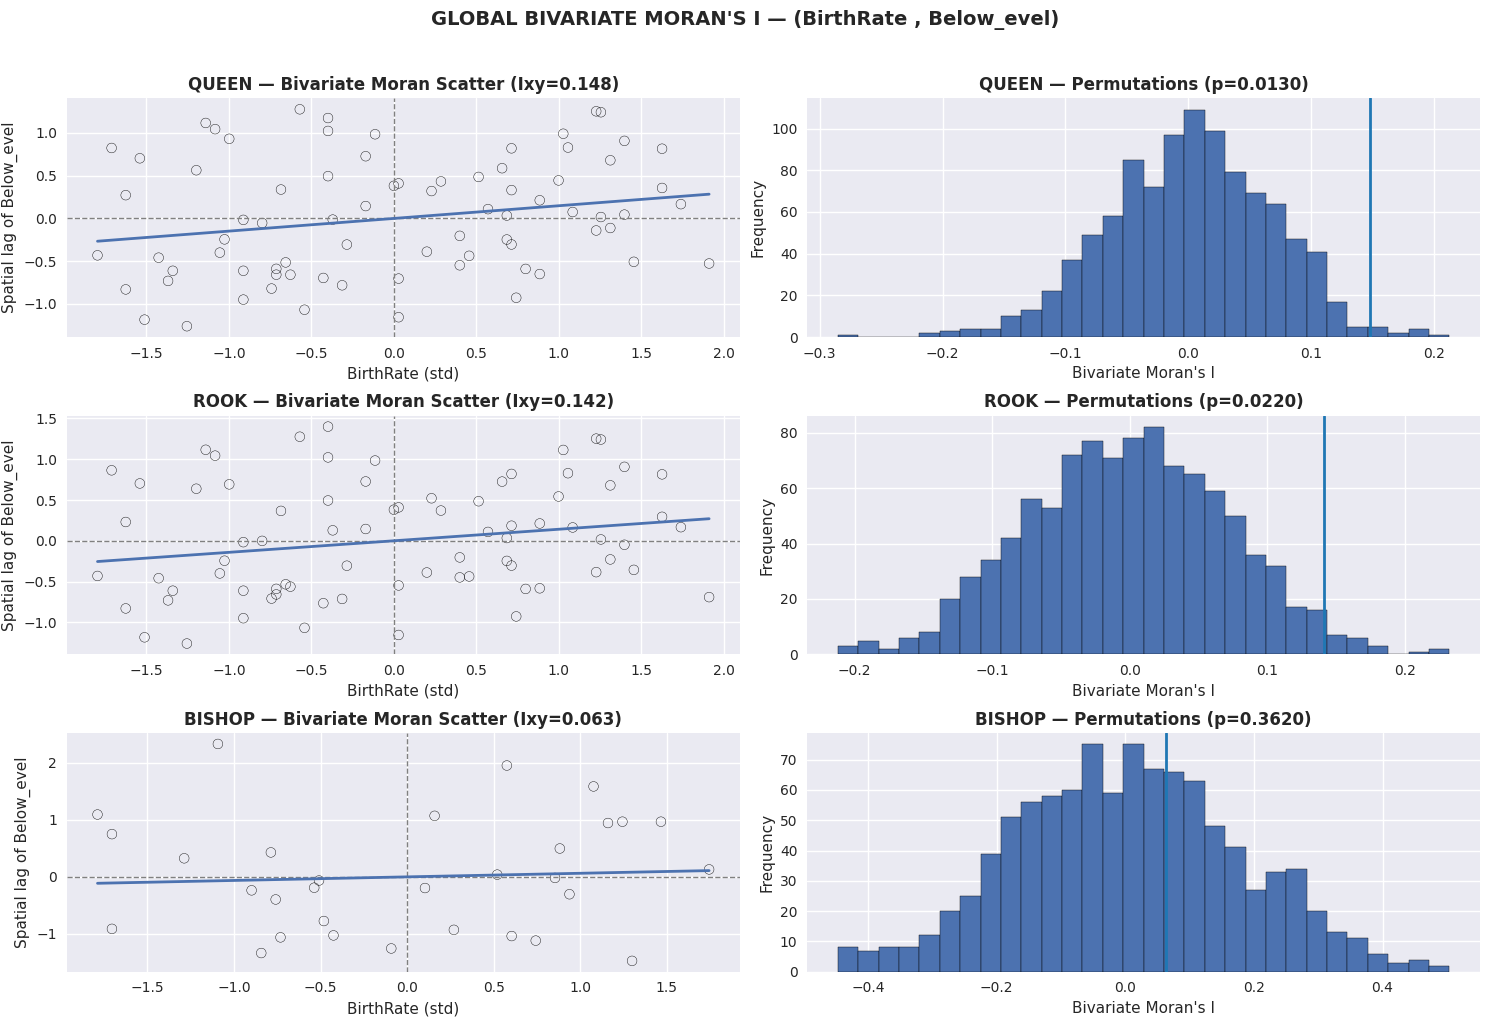

In [ ]:
gdf = gpd.read_file("../healthindicators/HealthIndicators.shp")

tab, fig, out = global_moran_bv(
    gdf=gdf,
    x_fields=["BirthRate"],
    y_fields=["Below_evel"],
    contiguities=("queen", "rook", "bishop"),
    permutations=999,
    alpha=0.05,
    standardize_xy=True,
    dashboard_pair=("BirthRate", "Below_evel"),
)

display(tab)
plt.show()


---